In [1]:
import os
import time
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import cv2

from src.models import load_model
from src.visualization import get_heatmap, show_mask_on_image, load_and_transform_image_mask
from evaluate_seg import compute_bce_with_logits_mask
from src.transform import image_transform_test, mask_transform
from src.mask import get_mask

from src.graph import generate_plot_from_files, read_coordinates, read_arcs


## Warnings
import warnings
warnings.filterwarnings("ignore", message="Clipping input data to the valid range")


c:\Users\rabas\anaconda3\envs\VRP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from hydra import initialize, compose
from omegaconf import OmegaConf
import torch
from src.models import load_model

# 🌀 Setup Hydra manually
with initialize(version_base=None, config_path="config"):
    cfg = compose(config_name="config", overrides=["data=config7", "model=resnet", "model.weight_path=checkpoints/resnet_8_30_7.pth"])

# Tu peux afficher la config complète si besoin :
# print(OmegaConf.to_yaml(cfg))

# 🧠 Charger le modèle une fois
cfg.load_model = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = load_model(cfg.model.name, device, cfg.model).eval()
print(f"✅ Model loaded: {cfg.model.name}")

{'name': 'resnet', 'load': '${..load_model}', 'save': '${..save_model}', 'kernel_size': 7, 'weight_path': 'checkpoints/resnet_8_30_7.pth', 'image_size': '${image_size}', 'mask_shape': '${mask_shape}', 'freeze': True, 'params': {'learning_rate': 0.0001, 'batch_size': '${...batch_size}', 'epochs': 20}, 'heatmap': {'method': 'gradcam', 'args': {'class_index': 1, 'target_layer': 'backbone.layer4.1.conv2'}}}
Loading weights from checkpoints/resnet_8_30_7.pth
✅ Model loaded: resnet


In [3]:

print(f"[Notebook] Model loaded: {cfg.model.name}")

# ── Choose image(s) to visualize ─────────────────────
image_dir = "data/plots/configuration1"
mask_dir = "data/MSH/mask_classic/mask7"
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])
modified_dir = "data/plots/configuration7"

[Notebook] Model loaded: resnet



Processing 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor([0.0068, 0.9734], grad_fn=<ToCopyBackward0>)
[timer] 1 took 2.26


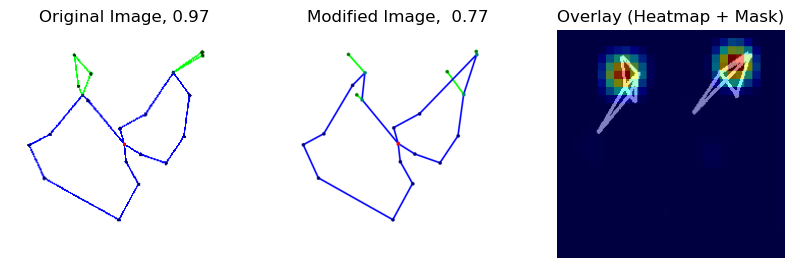


Processing 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor([0.0046, 0.9790], grad_fn=<ToCopyBackward0>)
[timer] 6 took 1.92


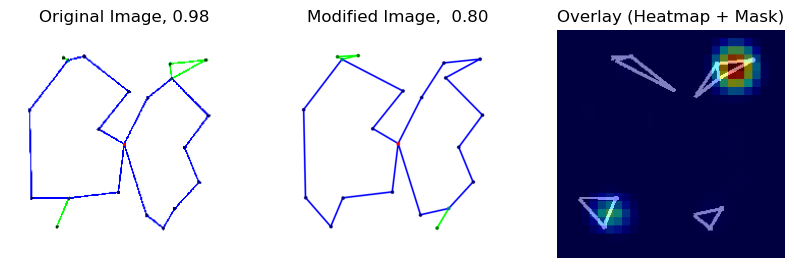


Processing 11


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor([5.1977e-04, 9.9653e-01], grad_fn=<ToCopyBackward0>)
[timer] 11 took 2.80


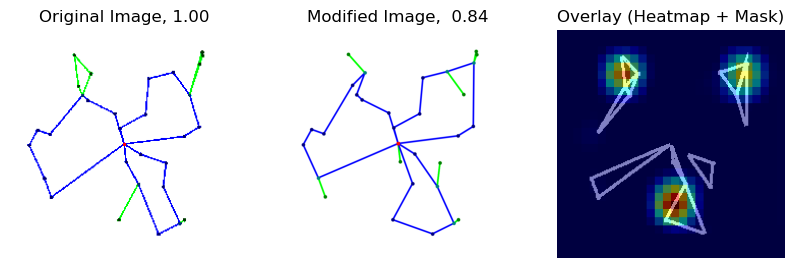


Processing 16


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor([0.0185, 0.9100], grad_fn=<ToCopyBackward0>)
[timer] 16 took 2.29


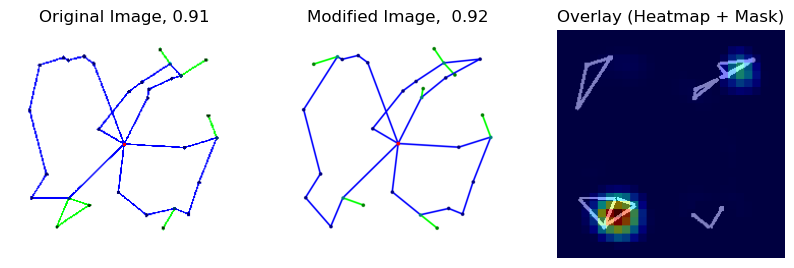


Processing 21


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor([0.2947, 0.4752], grad_fn=<ToCopyBackward0>)
[timer] 21 took 3.10


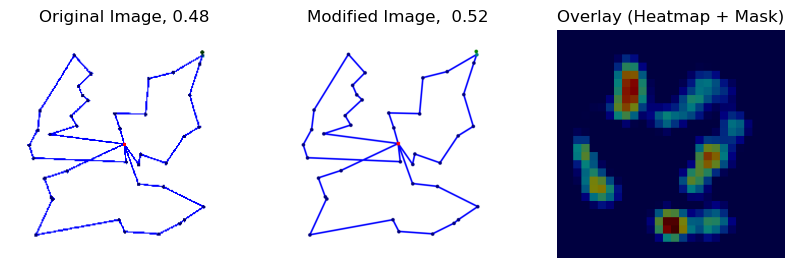


Processing 26


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor([0.2620, 0.5158], grad_fn=<ToCopyBackward0>)
[timer] 26 took 3.22


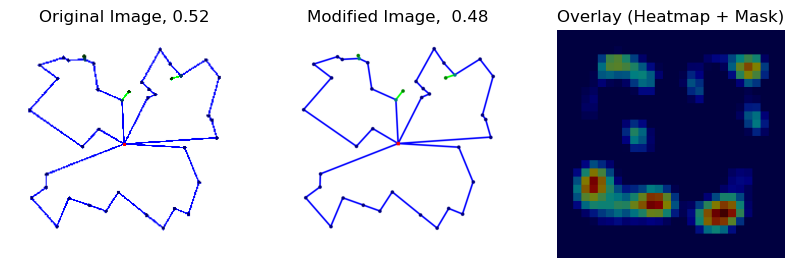


Processing 31


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor([0.0051, 0.9723], grad_fn=<ToCopyBackward0>)
[timer] 31 took 3.63


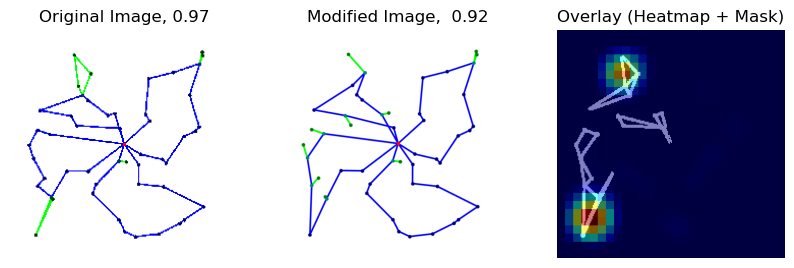


Processing 36


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor([0.2858, 0.4405], grad_fn=<ToCopyBackward0>)
[timer] 36 took 4.80


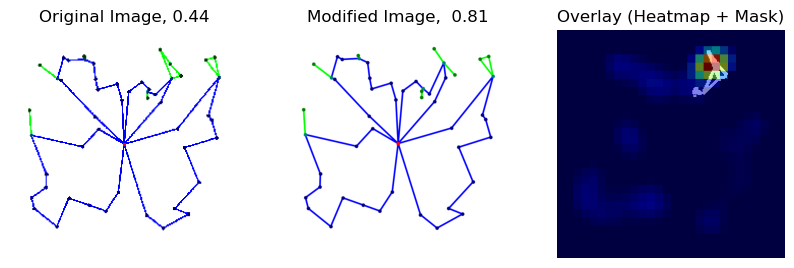


Processing 41


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor([0.0013, 0.9906], grad_fn=<ToCopyBackward0>)
[timer] 41 took 4.17


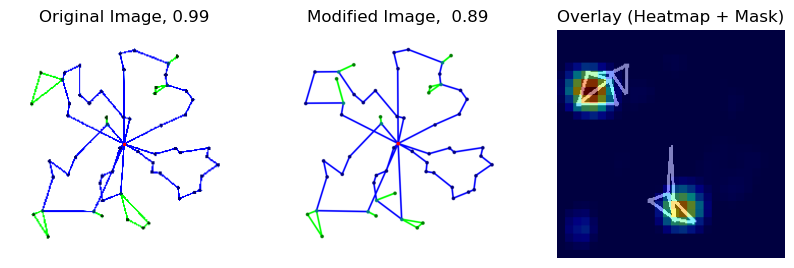


Processing 46


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor([0.1252, 0.6765], grad_fn=<ToCopyBackward0>)
[timer] 46 took 4.48


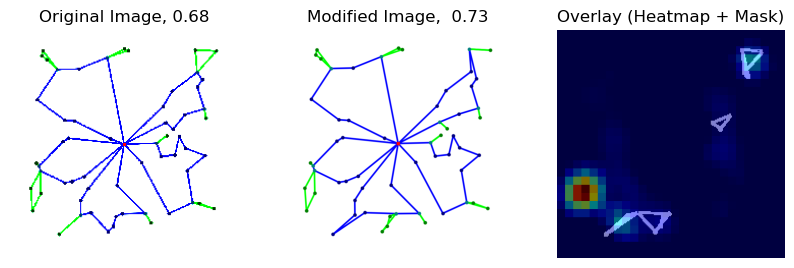


Processing 51


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor([0.3485, 0.3708], grad_fn=<ToCopyBackward0>)
[timer] 51 took 4.52


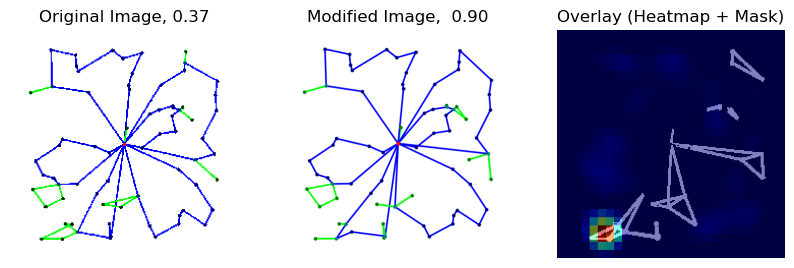


Processing 56


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor([0.5256, 0.2057], grad_fn=<ToCopyBackward0>)
[timer] 56 took 3.22


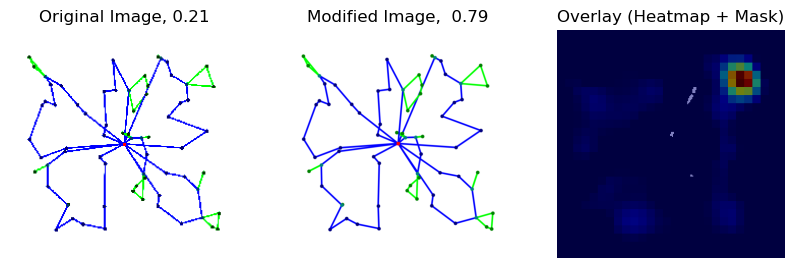

In [17]:
for number in range(1,60,5):  # change to [0] or other slice to limit
    
    coord_path = f"MSH/MSH/instances/Coordinates_{number}.txt"
    arc_path = f"MSH/MSH/results/configuration1/Arcs_{number}_1.txt"
    modified_arcs_path = f"MSH/MSH/results/configuration7/Arcs_{number}_1.txt"


    print(f"\nProcessing {number}")

    start = time.perf_counter()
    original_array = generate_plot_from_files(
        arcs_file=arc_path, coords_file=coord_path, bounds=(-1, 11, -1, 11)
    )
    original_img = Image.fromarray(original_array)
    img_tensor = image_transform_test()(original_img)
    img_tensor = img_tensor.unsqueeze(0).to(device)

    modified_array = generate_plot_from_files(
        arcs_file=modified_arcs_path, coords_file=coord_path, bounds=(-1, 11, -1, 11)
    )
    modified_img = Image.fromarray(modified_array)
    modified_img_tensor = image_transform_test()(modified_img)
    modified_img_tensor = modified_img_tensor.unsqueeze(0).to(device)

    mask = get_mask(original_array, modified_array)
    mask_img = Image.fromarray(mask)
    t_mask = mask_transform()(mask_img).unsqueeze(0)  # Transform and add batch dimension


    
    heatmap = get_heatmap(cfg.heatmap.method, model, img_tensor, cfg.heatmap.args, device=device, percentile_for_thresh = 70)
    prediction = model(img_tensor.to(device))
    pred_probab = torch.sigmoid(prediction).squeeze().cpu()[1]
    print(torch.sigmoid(prediction).squeeze().cpu())
    pred_probab_modif = 1-torch.sigmoid(model(modified_img_tensor.to(device))).squeeze().cpu()[1]

    # Overlay image
    overlay = show_mask_on_image(t_mask, heatmap, alpha=0.5, interpolation=cv2.INTER_NEAREST)

    # Compute loss
    loss = compute_bce_with_logits_mask(heatmap, t_mask)
    print(f"[timer] {number} took {time.perf_counter() - start:.2f}")
    fig, axs = plt.subplots(1, 3, figsize=(10, 6))
    axs[0].imshow(img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())
    axs[0].set_title("Original Image, {:.2f}".format(pred_probab.item()))
    axs[1].imshow(modified_img)
    axs[1].set_title("Modified Image,  {:.2f}".format(pred_probab_modif.item()))
    axs[2].imshow(overlay)
    axs[2].set_title("Overlay (Heatmap + Mask)")


    for ax in axs:
        ax.axis("off")
    plt.show()